## Example model with waveform injected in soma
#### Define the class of cell model and the class of simulation
Need to first import modules from the folder "stylized_module".

In [1]:
from stylized_module.stylized_cell import Stylized_Cell
from stylized_module.ecp import EcpMod, newposition
from stylized_module.recorder import Recorder

class Cell(Stylized_Cell):
    """Define single cell model using parent class Stylized_Cell"""
    def __init__(self,geometry=None,dL=30,vrest=-70.0):
        """
        Initialize cell model
        geometry: pandas dataframe of cell morphology properties
        dL: maximum segment length
        vrest: reversal potential of leak channel for all segments
        """
        super().__init__(geometry,dL,vrest)
        self.record_soma_v() # uncomment this if want to record soma voltage
    
    def set_channels(self):
        """Define biophysical properties, insert channels"""
#         self.set_all_passive(gl=0.0003)  # soma,dend both have gl
        gl_soma=15e-5
        gl_dend=1e-5
        for sec in self.all:
            sec.cm = 1.0
            sec.insert('pas')
            sec.e_pas = self._vrest
        self.soma.g_pas = gl_soma
        for sec in self.all[1:]:
            sec.g_pas = gl_dend
    
    def record_soma_v(self):
        self.v_rec = Recorder(self.soma(.5),'v')
    
    def v(self):
        """Return recorded soma membrane voltage in numpy array"""
        if hasattr(self,'v_rec'):
            return self.v_rec.as_numpy()

In [2]:
from neuron import h
import pandas as pd
import numpy as np

h.load_file('stdrun.hoc')

class Simulation(object):
    def __init__(self,geometry,electrodes,soma_injection,loc_param,geo_param=None,scale=1.0):
        """
        Initialize simulation object
        geometry: pandas dataframe of cell morphology properties
        electrodes: array of electrode coordinates, n-by-3
        soma_injection: vector of some injection waveform
        loc_param: location parameters, ncell-by-4 array
        geo_param: geometry parameters, ncell-by-k array, if not specified, use default properties in geometry
        scale: scaling factors of lfp magnitude, ncell-vector, if is single value, is constant for all cells
        """
        self.ncell = 0  # number of cells in this simulation
        self.cells = []  # list of cell object
        self.lfp = []  # list of EcpMod object
        self.define_geometry_entries()  # list of entries to geometry dataframe
        self.geometry = geometry.copy()
        self.electrodes = electrodes
        self.soma_injection = soma_injection
        self.set_loc_param(loc_param)  # setup variable location parameters
        self.set_geo_param(geo_param)  # setup variable geometry parameters
        self.set_scale(scale)  # setup scaling factors of lfp magnitude
        self.create_cells()  # create cell objects with properties set up
        self.t_vec = h.Vector( round(h.tstop/h.dt)+1 ).record(h._ref_t)  # record time
    
    def set_loc_param(self,loc_param):
        """Setup location parameters. loc_param ncell-by-4 array"""
        loc_param = np.array(loc_param)
        if loc_param.ndim==1:
            loc_param = np.expand_dims(loc_param,0)
        self.ncell = loc_param.shape[0]
        self.loc_param = [(np.insert(loc_param[i,:2],2,0.),np.insert(loc_param[i,2:],0,0.)) for i in range(self.ncell)]
    
    def set_geo_param(self,geo_param):
        """Setup geometry parameters. geo_param ncell-by-k array, k entries of properties"""
        if geo_param is None:
            self.geo_param = None
        else:
            geo_param = np.array(geo_param)
            if geo_param.ndim==1:
                geo_param = np.expand_dims(geo_param,0)
            if geo_param.shape[0]!=self.ncell:
                raise ValueError("geo_param number of rows does not match loc_param")
            self.geo_param = geo_param
    
    def set_scale(self,scale):
        if not hasattr(scale,'__len__'):
            self.scale = np.full(self.ncell,scale)
        else:
            scale = np.array(scale).ravel()
            if scale.size!=self.ncell:
                raise ValueError("scale size does not match loc_param rows")
            self.scale = scale
    
    def define_geometry_entries(self):
        """Define list of entries to geometry dataframe. Each entry is a pair of section id and property."""
        self.geo_entries = [
            (0,'R'),  # change soma radius
            (3,'L'),  # change trunk length
            (3,'R'),  # change trunk radius
            ([1,2],'R'),  # change dendrites radius
            (4,'R'),  # change tuft radius
            ([1,2,4],'L') # change dendrite length
        ]
    
    def set_geometry(self,geometry,geo_param):
        """Set property values from geo_param through each entry to geometry. Return dataframe"""
        geom = geometry.copy()
        for i,x in enumerate(geo_param):
            if x>=0:
                geom.loc[self.geo_entries[i]] = x
        return geom
    
    def create_cells(self):
        """Create cell objects with properties set up"""
        self.cells.clear()  # remove cell objects from previous run
        self.lfp.clear()
        if self.geo_param is None:
            for i in range(self.ncell):
                self.cells.append( Cell(geometry=self.geometry) )
        else:
            for i in range(self.ncell):
                geometry = self.set_geometry(self.geometry,self.geo_param[i,:])
                self.cells.append( Cell(geometry=geometry) )
        # add soma injection current and set up lfp recording
        min_dist = 10.0 # minimum distance allowed between segment and electrode. Set to None if not using.
        for i,cell in enumerate(self.cells):
            cell.add_injection(sec_index=0,pulse=False,current=self.soma_injection,record=True)
            # Move cell location
            self.lfp.append( EcpMod(cell,self.electrodes,move_cell=self.loc_param[i],scale=self.scale[i],min_distance=min_dist) )
#             # Alternatively, if number of segments in the cell is much larger then electrodes, then move the electrodes instead
#             translate, rotate = self.loc_param[i]
#             self.lfp.append( EcpMod(cell,newposition(translate,rotate,self.electrodes,move_frame=True),scale=self.scale[i],min_distance=min_dist) )
    
    def run(self):
        """Run simulation"""
        h.run()
    
    def t(self):
        """Return simulation time vector"""
        return self.t_vec.as_numpy()
    
    def get_lfp(self,index=0):
        """Return LFP array of the cell by index, channels-by-time"""
        return self.lfp[index].calc_ecp()
    

#### Begin setup the simulation

In [3]:
from neuron import h
import pandas as pd
import numpy as np

# Load geometry into pandas dataframe
geo_standard = pd.read_csv('geom_standard.csv',index_col='id')
# Load electrode coordinates (this is just for example. update it to be 96*3)
elec_pos = pd.read_csv('linear_electrode.csv',sep=' ')[[x+'_pos' for x in list('xyz')]].values

# Basic settings for simulation
h.load_file('stdrun.hoc')
h.tstop = 20.
h.dt = 0.025
h.v_init = -70.0  # should be close to resting potential

# define example current injection waveform (later use in vivo LFP waveform in the channel with maximum amplitude)
t = np.arange(0,h.tstop+h.dt,h.dt)
t_inj = np.arange(5,15,h.dt)
soma_injection = np.zeros(t.shape)
idx = int(5/h.dt)
soma_injection[idx:idx+len(t_inj)] += 0.5*np.sin(2*np.pi*0.2*t_inj)  # simple sine wave

In [4]:
geo_standard  # startup geometry properties

,name,type,axial,L,R,ang,pid
id,,,,,,,
0,soma,1,True,0.0,6.0,0.000000,0
1,basal,3,False,200.0,0.1,-0.707107,0
2,apical,4,False,200.0,0.1,0.000000,0
3,trunk,4,True,400.0,0.1,1.570796,0
4,tuft,4,False,200.0,0.1,0.707107,3


In [5]:
# obtain random location parameters
prior_min = np.array([0,-2000,-1,0])
prior_max = np.array([200,2000,1,np.pi])
nsamples = 1
loc_param = np.random.uniform(prior_min,prior_max,size=(nsamples,4))
loc_param

array([[1.09564924e+02, 1.83870851e+03, 4.62625524e-01, 1.57036400e+00]])

Create simulation object. Here run with only one cell and only location changed.

In [6]:
sim = Simulation(geo_standard,elec_pos,soma_injection,loc_param,scale=100.)  # LFP scaled by 100 times for all cells

In [7]:
sim.run()  # run simulation
lfp = sim.get_lfp()  # get lfp array

Check the result

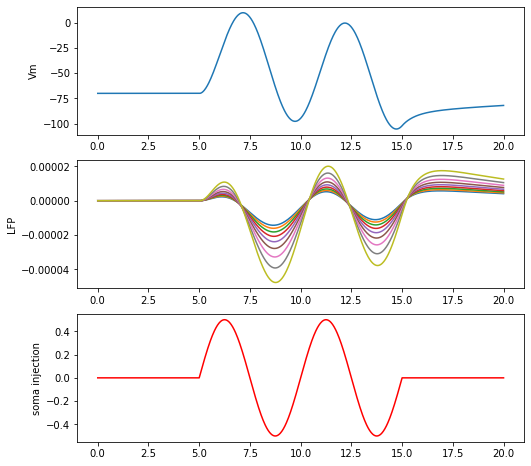

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,8))
plt.subplot(311)
plt.plot(sim.t(),sim.cells[0].v())
plt.ylabel('Vm')
plt.subplot(312)
for i in range(lfp.shape[0]):
    plt.plot(sim.t(),lfp[i,:])
plt.ylabel('LFP')
plt.subplot(313)
plt.plot(t,soma_injection,'r')
plt.ylabel('soma injection')
plt.show()

Now try to run with 3 cells, with 3 different locations, and with geometry properties changed.

In [9]:
nsamples = 3
loc_param = np.random.uniform(prior_min,prior_max,size=(nsamples,4))
loc_param

array([[ 5.32534108e+01,  1.86474806e+03,  9.88491498e-01,
         1.49183212e+00],
       [ 9.03648686e+01,  1.22088258e+03, -6.71642971e-02,
         1.93025974e+00],
       [ 1.62478107e+02, -1.89211894e+03,  6.15567962e-01,
         2.90679426e+00]])

Set the geometry parameters. Look up "define_geometry_entries" in the simulation class for corresponding properties. Set to -1 if do not want to change.

In [10]:
geo_param = [4.0, -1, 0.2, -1, -1, 300.0]  # default value [6.0, 400.0, 0.1, 0.1, 0.1, 200.0]
geo_param = np.tile(geo_param,(nsamples,1))  # Repeat to get 3-by-6 array.
# Here I just use the same setting for the 3 cells, but it could be different for different cells.
print(geo_param)
sim.set_geometry(geo_standard,geo_param[0,:])  # show the modified geometry dataframe

[[ 4.e+00 -1.e+00  2.e-01 -1.e+00 -1.e+00  3.e+02]
 [ 4.e+00 -1.e+00  2.e-01 -1.e+00 -1.e+00  3.e+02]
 [ 4.e+00 -1.e+00  2.e-01 -1.e+00 -1.e+00  3.e+02]]


,name,type,axial,L,R,ang,pid
id,,,,,,,
0,soma,1,True,0.0,4.0,0.000000,0
1,basal,3,False,300.0,0.1,-0.707107,0
2,apical,4,False,300.0,0.1,0.000000,0
3,trunk,4,True,400.0,0.2,1.570796,0
4,tuft,4,False,300.0,0.1,0.707107,3


Get random scaling factor between 1 and 100.

In [11]:
scale = np.random.uniform(1.,100.,size=nsamples)
scale

array([75.95775185, 10.60808365,  9.85513707])

This block of codes below can be put into the simulator function in sbi, to be run multiple times. You can run one cell at a time and run through all samples in series. Or you can run multiple cells at once, and gather the results as presimulated data for each round in sbi.

In [12]:
sim.set_loc_param(loc_param)
sim.set_geo_param(geo_param)
sim.set_scale(scale)
sim.create_cells()
sim.run()

Check result of the third cell

In [13]:
lfp = sim.get_lfp(2)  # get lfp by cell index 2

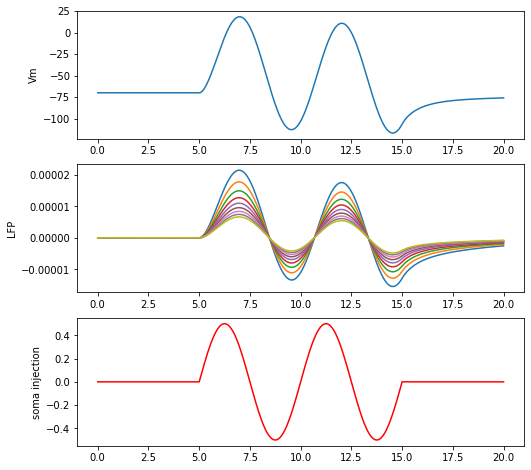

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,8))
plt.subplot(311)
plt.plot(sim.t(),sim.cells[2].v())
plt.ylabel('Vm')
plt.subplot(312)
for i in range(lfp.shape[0]):
    plt.plot(sim.t(),lfp[i,:])
plt.ylabel('LFP')
plt.subplot(313)
plt.plot(t,soma_injection,'r')
plt.ylabel('soma injection')
plt.show()

### Check some model features

In [15]:
from neuron import h

h.topology()


|-|       soma(0-1)
   `---------|       basal(0-1)
   `---------|       basal(0-1)
   `---------|       apical(0-1)
   `---------|       apical(0-1)
   `-------------|       trunk(0-1)
                  `---------|       tuft(0-1)
                  `---------|       tuft(0-1)
|-|       soma(0-1)
   `---------|       basal(0-1)
   `---------|       basal(0-1)
   `---------|       apical(0-1)
   `---------|       apical(0-1)
   `-------------|       trunk(0-1)
                  `---------|       tuft(0-1)
                  `---------|       tuft(0-1)
|-|       soma(0-1)
   `---------|       basal(0-1)
   `---------|       basal(0-1)
   `---------|       apical(0-1)
   `---------|       apical(0-1)
   `-------------|       trunk(0-1)
                  `---------|       tuft(0-1)
                  `---------|       tuft(0-1)



1.0

<IPython.core.display.Javascript object>


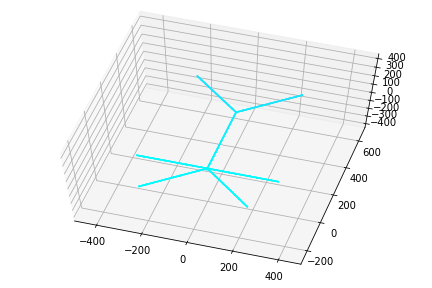

In [17]:
import matplotlib.pyplot as plt
%matplotlib notebook

ps = h.PlotShape()
ps.plot(plt)
plt.show()

In [16]:
# Used for calculating LFP
sim.cells[0].seg_coords  # for all segments, dl: segment length direction vertor, pc: segment center coordinates, d: diameter

{'dl': array([[  0.        ,   8.        ,   0.        ],
        [ 22.80733795, -19.48910828,   0.        ],
        [ 22.80733795, -19.48910828,   0.        ],
        [ 22.80733795, -19.48910828,   0.        ],
        [ 22.80733795, -19.48910828,   0.        ],
        [ 22.80733795, -19.48910828,   0.        ],
        [ 22.80733795, -19.48910828,   0.        ],
        [ 22.80733795, -19.48910828,   0.        ],
        [ 22.80733795, -19.48910828,   0.        ],
        [ 22.80733795, -19.48910828,   0.        ],
        [ 22.80733795, -19.48910828,   0.        ],
        [-22.80733795, -19.48910828,   0.        ],
        [-22.80733795, -19.48910828,   0.        ],
        [-22.80733795, -19.48910828,   0.        ],
        [-22.80733795, -19.48910828,   0.        ],
        [-22.80733795, -19.48910828,   0.        ],
        [-22.80733795, -19.48910828,   0.        ],
        [-22.80733795, -19.48910828,   0.        ],
        [-22.80733795, -19.48910828,   0.        ],
      